# Label author status
Label author status according to (1) prior comment count (\~ experience); (2) location; (3) prior comment length (\~ engagement).

In [1]:
# load comments
comment_data_dir = '../../data/nyt_comments/'
month_year_pairs = [
    ('Jan', '2017'), 
    ('Feb', '2017'),
    ('March', '2017'),
    ('April', '2017'),
    ('Jan', '2018'), 
    ('Feb', '2018'),
    ('March', '2018'),
    ('April', '2018'),
]
import os
import pandas as pd
comment_data = []
comment_data_cols = ['articleID', 'commentBody', 'commentID', 'commentType', 'createDate', 
                     'depth', 'parentID', 'recommendedFlag', 
                     'reportAbuseFlag', 'sectionName', 
                     'userID', 'userDisplayName', 'userLocation']
for month_i, year_i in month_year_pairs:
    comment_data_file_i = os.path.join(comment_data_dir, f'Comments{month_i}{year_i}.csv')
    comment_data_i = pd.read_csv(comment_data_file_i, sep=',', index_col=False, usecols=comment_data_cols)
    comment_data.append(comment_data_i)
comment_data = pd.concat(comment_data, axis=0)

<ipython-input-1-29bceb687512>:24: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  comment_data = pd.concat(comment_data, axis=0)


In [2]:
## add simplified date value
from datetime import datetime
def round_date_to_day(time_stamp):
    raw_date = datetime.fromtimestamp(time_stamp)
    round_date = datetime(year=raw_date.year, month=raw_date.month, day=raw_date.day)
    return round_date
comment_data = comment_data.assign(**{
    'date_day' : comment_data.loc[:, 'createDate'].apply(lambda x: round_date_to_day(x))
})
# print(datetime.fromtimestamp(comment_data.loc[:, 'createDate'].iloc[0]))
display(comment_data.head())

,articleID,commentBody,commentID,commentType,createDate,depth,parentID,recommendedFlag,reportAbuseFlag,sectionName,userDisplayName,userID,userLocation,date_day
0,58691a5795d0e039260788b9,For all you Americans out there --- still rejo...,20969730.0,comment,1.483426e+09,1.0,0.0,NaN,NaN,Politics,N. Smith,64679318.0,New York City,2017-01-03
1,58691a5795d0e039260788b9,Obamas policies may prove to be the least of t...,20969325.0,comment,1.483417e+09,1.0,0.0,NaN,NaN,Politics,Kilocharlie,69254188.0,Phoenix,2017-01-02
2,58691a5795d0e039260788b9,Democrats are comprised of malcontents who gen...,20969855.0,comment,1.483431e+09,1.0,0.0,NaN,NaN,Politics,Frank Fryer,76788711.0,Florida,2017-01-03
3,58691a5795d0e039260788b9,The picture in this article is the face of con...,20969407.0,comment,1.483419e+09,1.0,0.0,NaN,NaN,Politics,James Young,72718862.0,Seattle,2017-01-02
4,58691a5795d0e039260788b9,Elections have consequences.,20969274.0,comment,1.483417e+09,1.0,0.0,NaN,NaN,Politics,M.,7529267.0,Seattle,2017-01-02


In [3]:
def compute_prior_comment_count(full_data, date_var='date_day', author_var='userID'):
    """
    Compute prior number of comments/day per author.
    """
    comment_count_per_author = []
    for (author_i, date_i), data_i in full_data.groupby([author_var, date_var]):
        prior_data_i = full_data[(full_data.loc[:, 'userID']==author_i) & 
                                 (full_data.loc[:, date_var] <= date_i)]
        date_range_i = (prior_data_i.loc[:, date_var].max() - prior_data_i.loc[:, date_var].min()).days + 1 # "smooth" to avoid div-by-0
        comment_count_i = prior_data_i.shape[0] / date_range_i
        comment_count_per_author.append([author_i, date_i, comment_count_i])
    comment_count_per_author = pd.DataFrame(comment_count_per_author, columns=[author_var, date_var, 'prior_comment_count'])
    return comment_count_per_author
def compute_prior_comment_length(full_data, tokenizer, text_var='commentBody', date_var='date_day', author_var='userID'):
    """
    Compute prior length of comment per author.
    """
    comment_len_per_author = []
    # get tokens
    full_data = full_data.assign(**{
        'comment_tokens' : full_data.loc[:, 'commentBody'].apply(tokenizer.tokenize)
    })
    for (author_i, date_i), data_i in full_data.groupby([author_var, date_var]):
        prior_data_i = full_data[(full_data.loc[:, 'userID']==author_i) & 
                                 (full_data.loc[:, date_var] <= date_i)]
        comment_len_i = prior_data_i.loc[:, 'comment_tokens'].apply(lambda x: len(x))
        mean_comment_len_i = comment_len_i.mean()
        comment_len_per_author.append([author_i, date_i, mean_comment_len_i])
    comment_len_per_author = pd.DataFrame(comment_len_per_author, columns=[author_var, date_var, 'prior_comment_len'])
    return comment_len_per_author

In [4]:
# comment count
date_var = 'date_day'
author_var = 'userID'
comment_count_per_author = compute_prior_comment_count(comment_data, date_var=date_var, author_var=author_var)

In [ ]:
# comment length
from nltk.tokenize import WordPunctTokenizer
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import clean_text_matchers
import re
# clean HTML`
text_var = 'commentBody'
matcher_pairs = [
    (re.compile('<.+>'), ' '), #HTML
]
word_tokenizer = WordPunctTokenizer()
comment_data = comment_data.assign(**{
    text_var : comment_data.loc[:, text_var].apply(lambda x: clean_text_matchers(x, word_tokenizer, matcher_pairs))
})
comment_len_per_author = compute_prior_comment_length(comment_data, word_tokenizer, 
                                                      text_var=text_var, date_var=date_var,
                                                      author_var=author_var)

In [ ]:
## save to file
author_var = 'userID'
combined_comment_author_data = pd.merge(comment_count_per_author, comment_len_per_author, on=author_var)
combined_comment_author_data_file = '../../data/nyt_comments/author_comment_stats.tsv'
combined_comment_data.to_csv(combined_comment_author_data_file, sep='\t', index=False)

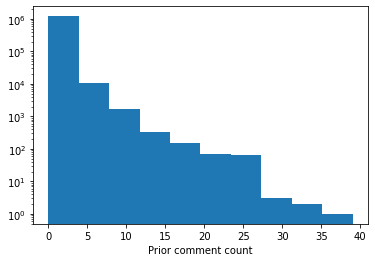

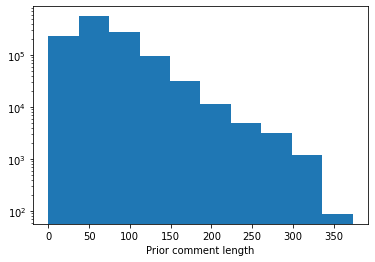

In [30]:
## display distribution of comment stats
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# comment count
plt.hist(comment_count_per_author.loc[:, 'prior_comment_count'])
plt.yscale('log')
plt.xlabel('Prior comment count')
plt.show()
# comment length
plt.hist(comment_len_per_author.loc[:, 'prior_comment_len'])
plt.yscale('log')
plt.xlabel('Prior comment length')
plt.show()

Now let's label authors by location: US vs. non-US.

In [42]:
## let's do some geocoding
import geocoder
def geocode_country(text):
    text_loc_country = 'UNK'
    try:
        text_loc = geocoder.osm(text, method='geocode')
        text_loc_data = text_loc.response.json()
        if(len(text_loc_data) > 0):
            text_loc_country = text_loc_data[0]['address']['country_code']
    except Exception as e:
        print(f'geocoding error {e}')
    return text_loc_country

author_locations = pd.Series(comment_data.loc[:, 'userLocation'].unique())
print(author_locations)
# DO NOT use parallel w/ too many workers => rate limit
from pandarallel import pandarallel
num_workers = 2
pandarallel.initialize(progress_bar=True, nb_workers=num_workers)
# from tqdm import tqdm
# tqdm.pandas()
author_location_countries = author_locations.parallel_apply(geocode_country)
# simple label: US vs. non-US
## convert country to region
# author_location_data = pd.DataFrame([unique_locations, unique_location_countries], index=['userLocation', 'user_country']).transpose()
# print(author_location_data)
# if('user_country' not in nyt_article_question_data.columns):
#     nyt_article_question_data = pd.merge(nyt_article_question_data, author_location_data, on='userLocation')
# from collections import defaultdict
# location_region_lookup = defaultdict(lambda : 'UNK')
# # country-region codes
# location_region_lookup.update(
#     {'ad': 'europe', 'ae': 'asia', 'af': 'asia', 'ag': 'north_america', 'ai': 'north_america', 'al': 'europe', 'am': 'asia', 'an': 'north_america', 'ao': 'africa', 'ap': 'asia', 'aq': 'antarctica', 'ar': 'south_america', 'as': 'oceania', 'at': 'europe', 'au': 'oceania', 'aw': 'north_america', 'ax': 'europe', 'az': 'asia', 'ba': 'europe', 'bb': 'north_america', 'bd': 'asia', 'be': 'europe', 'bf': 'africa', 'bg': 'europe', 'bh': 'asia', 'bi': 'africa', 'bj': 'africa', 'bl': 'north_america', 'bm': 'north_america', 'bn': 'asia', 'bo': 'south_america', 'br': 'south_america', 'bs': 'north_america', 'bt': 'asia', 'bv': 'antarctica', 'bw': 'africa', 'by': 'europe', 'bz': 'north_america', 'ca': 'north_america', 'cc': 'asia', 'cd': 'africa', 'cf': 'africa', 'cg': 'africa', 'ch': 'europe', 'ci': 'africa', 'ck': 'oceania', 'cl': 'south_america', 'cm': 'africa', 'cn': 'asia', 'co': 'south_america', 'cr': 'north_america', 'cu': 'north_america', 'cv': 'africa', 'cx': 'asia', 'cy': 'asia', 'cz': 'europe', 'de': 'europe', 'dj': 'africa', 'dk': 'europe', 'dm': 'north_america', 'do': 'north_america', 'dz': 'africa', 'ec': 'south_america', 'ee': 'europe', 'eg': 'africa', 'eh': 'africa', 'er': 'africa', 'es': 'europe', 'et': 'africa', 'eu': 'europe', 'fi': 'europe', 'fj': 'oceania', 'fk': 'south_america', 'fm': 'oceania', 'fo': 'europe', 'fr': 'europe', 'fx': 'europe', 'ga': 'africa', 'gb': 'europe', 'gd': 'north_america', 'ge': 'asia', 'gf': 'south_america', 'gg': 'europe', 'gh': 'africa', 'gi': 'europe', 'gl': 'north_america', 'gm': 'africa', 'gn': 'africa', 'gp': 'north_america', 'gq': 'africa', 'gr': 'europe', 'gs': 'antarctica', 'gt': 'north_america', 'gu': 'oceania', 'gw': 'africa', 'gy': 'south_america', 'hk': 'asia', 'hm': 'antarctica', 'hn': 'north_america', 'hr': 'europe', 'ht': 'north_america', 'hu': 'europe', 'id': 'asia', 'ie': 'europe', 'il': 'asia', 'im': 'europe', 'in': 'asia', 'io': 'asia', 'iq': 'asia', 'ir': 'asia', 'is': 'europe', 'it': 'europe', 'je': 'europe', 'jm': 'north_america', 'jo': 'asia', 'jp': 'asia', 'ke': 'africa', 'kg': 'asia', 'kh': 'asia', 'ki': 'oceania', 'km': 'africa', 'kn': 'north_america', 'kp': 'asia', 'kr': 'asia', 'kw': 'asia', 'ky': 'north_america', 'kz': 'asia', 'la': 'asia', 'lb': 'asia', 'lc': 'north_america', 'li': 'europe', 'lk': 'asia', 'lr': 'africa', 'ls': 'africa', 'lt': 'europe', 'lu': 'europe', 'lv': 'europe', 'ly': 'africa', 'ma': 'africa', 'mc': 'europe', 'md': 'europe', 'me': 'europe', 'mf': 'north_america', 'mg': 'africa', 'mh': 'oceania', 'mk': 'europe', 'ml': 'africa', 'mm': 'asia', 'mn': 'asia', 'mo': 'asia', 'mp': 'oceania', 'mq': 'north_america', 'mr': 'africa', 'ms': 'north_america', 'mt': 'europe', 'mu': 'africa', 'mv': 'asia', 'mw': 'africa', 'mx': 'north_america', 'my': 'asia', 'mz': 'africa', 'na': 'africa', 'nc': 'oceania', 'ne': 'africa', 'nf': 'oceania', 'ng': 'africa', 'ni': 'north_america', 'nl': 'europe', 'no': 'europe', 'np': 'asia', 'nr': 'oceania', 'nu': 'oceania', 'nz': 'oceania', 'om': 'asia', 'pa': 'north_america', 'pe': 'south_america', 'pf': 'oceania', 'pg': 'oceania', 'ph': 'asia', 'pk': 'asia', 'pl': 'europe', 'pm': 'north_america', 'pn': 'oceania', 'pr': 'north_america', 'ps': 'asia', 'pt': 'europe', 'pw': 'oceania', 'py': 'south_america', 'qa': 'asia', 're': 'africa', 'ro': 'europe', 'rs': 'europe', 'ru': 'europe', 'rw': 'africa', 'sa': 'asia', 'sb': 'oceania', 'sc': 'africa', 'sd': 'africa', 'se': 'europe', 'sg': 'asia', 'sh': 'africa', 'si': 'europe', 'sj': 'europe', 'sk': 'europe', 'sl': 'africa', 'sm': 'europe', 'sn': 'africa', 'so': 'africa', 'sr': 'south_america', 'st': 'africa', 'sv': 'north_america', 'sy': 'asia', 'sz': 'africa', 'tc': 'north_america', 'td': 'africa', 'tf': 'antarctica', 'tg': 'africa', 'th': 'asia', 'tj': 'asia', 'tk': 'oceania', 'tl': 'asia', 'tm': 'asia', 'tn': 'africa', 'to': 'oceania', 'tr': 'europe', 'tt': 'north_america', 'tv': 'oceania', 'tw': 'asia', 'tz': 'africa', 'ua': 'europe', 'ug': 'africa', 'um': 'oceania', 'us': 'north_america', 'uy': 'south_america', 'uz': 'asia', 'va': 'europe', 'vc': 'north_america', 've': 'south_america', 'vg': 'north_america', 'vi': 'north_america', 'vn': 'asia', 'vu': 'oceania', 'wf': 'oceania', 'ws': 'oceania', 'ye': 'asia', 'yt': 'africa', 'za': 'africa', 'zm': 'africa', 'zw': 'africa', 'UNK' : 'UNK'}
# )
# nyt_article_question_data = nyt_article_question_data.assign(**{
#     'user_region' : nyt_article_question_data.loc[:, 'user_country'].apply(lambda x: location_region_lookup[x])
# })
# print(nyt_article_question_data.loc[:, 'user_country'].value_counts().head(10))
# print(nyt_article_question_data.loc[:, 'user_region'].value_counts().head(10))
# test = 'Chicago'
# test_country = geocode_country(test)
# print(test_country)

### Test classification by author type

Before we use these features to blindly generate text, let's see how well we can classify the author status based on the comment text, i.e. weak version of authorship attribution.

We'll combine the representation of the article text and the comment text as a single input representation to predict the output (author "class").

In [ ]:
## convert continuous variables into binary categories
import numpy as np
comment_count_cutoff_pct = [25]
comment_len_cutoff_pct = [50]
combined_comment_author_data = pd.read_csv('../../data/nyt_comments/comment_author_stats.tsv', sep='\t', index_col=False)
